In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


# Loading the dataset

In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Deeper Network (2 hidden layers)

To get from the perceptron to mlp we expanded the model with many parallel matrix operations. Now we can try to make it deeper, with more operations happening in series. <br>
This is especially poerful because biological neurons fire around 100 times a second, it takes a human 100ms to identify an object, so it stands to reason that a 10 layer network should be able to do complex tasks.  

In [4]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=2).to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())


4.192885398864746
2.261554718017578
1.991166353225708
1.8070677518844604
1.7726620435714722
1.7149920463562012
1.6656062602996826
1.6533596515655518
1.6423976421356201
1.6053873300552368


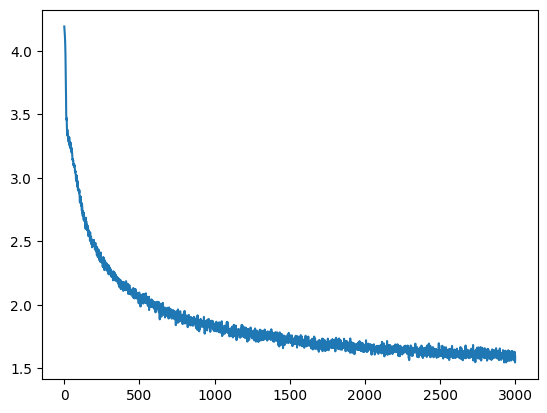

In [5]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Much deeper network (20 layers)

In [6]:
class Model(nn.Module):  # Same model class as before
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx:
            x = F.gelu(hidden(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=20).to(device)  # increased to 20 layers 

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

4.177122116088867
3.304553747177124
2.7845544815063477
2.4760520458221436
2.3655710220336914
2.305896520614624
2.2565414905548096
2.2369232177734375
2.1252639293670654
2.1125378608703613


The network with 20 hidden layers is unable to train effectively, thats because the derivatives don't flow well between the layers

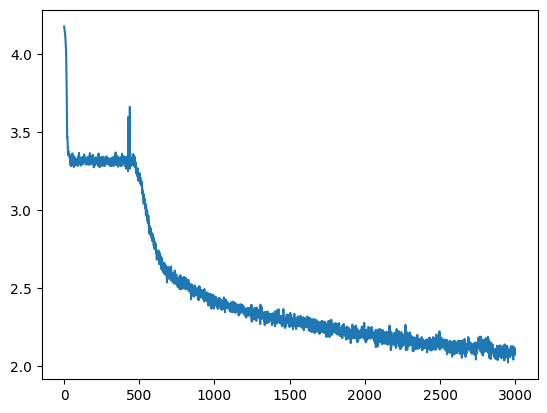

In [7]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Residual connections

In [15]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + F.gelu(hidden(x))  # added skip connection 
        return self.fc2(x)
    

device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=20).to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())


6.957232475280762
2.3823535442352295
1.9971259832382202
1.8433135747909546
1.7501280307769775
1.7008434534072876
1.602887511253357
1.5925037860870361
1.5573304891586304
1.5346522331237793


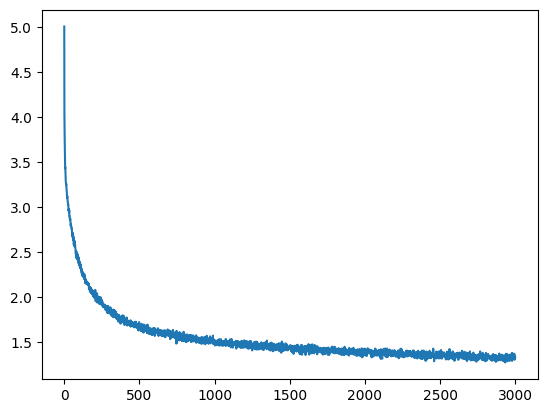

In [9]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Deeper (56 layers) 

In [16]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + F.gelu(hidden(x))  
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=56).to(device)  # increased to 56 layers

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

4827.3720703125
3.3017561435699463
3.1956193447113037
3.063947916030884
2.949216365814209
2.7807059288024902
2.5495495796203613
2.4275803565979004
2.313406229019165
2.2214441299438477


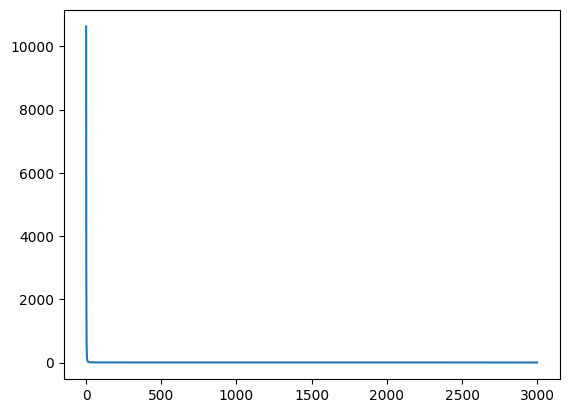

In [11]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

deeper connections allow us to go up to crazy amounts of layers, but we instantly notice the unreasonably high loss at the start, we solved this problem before by decreasing the parameter values at initialization, but if we go down more we are going to get extremely low values. Restricting the flow of information through the network<br><br>
We want the information in the neurons to travel through the network while not getting blown out to crazy high values. To do that we can normalize the neurons with layernorm, so that std = 1 and mean = 0

(you might want to apply normalization only once in a while, not at every layer like this, but performance is similar so I'll just show this version)

In [22]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.BatchNorm1d(hidden_size)  # added batch norm

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = self.norm(x + F.gelu(hidden(x)))  
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=56).to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.232
Epoch _300 - Loss: 2.042
Epoch _600 - Loss: 1.729
Epoch _900 - Loss: 1.642
Epoch 1200 - Loss: 1.535
Epoch 1500 - Loss: 1.479
Epoch 1800 - Loss: 1.473
Epoch 2100 - Loss: 1.380
Epoch 2400 - Loss: 1.399
Epoch 2700 - Loss: 1.351


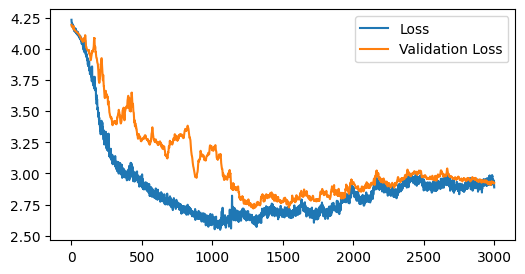

In [24]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [13]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        #print(X)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


             
KING RICHARD IEENES:
Let let a net
Unmen,--whither resolabert dead: here's my matter'd;
To her soul,
That utters
And I elooth the hear him wither?

BENVALT:
Happy, I cannot as that his midnight;
And get a swears,
Or if syrent it in.

LADY GREY:
Thing with surpomen with my sats of 'it.

BRUTUS:
Where you that ntil

# WAYY TOO DEEP
Just for fun lets try way more layers

In [23]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.BatchNorm1d(hidden_size)  

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = self.norm(x + F.gelu(hidden(x)))  
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=200).to(device)  # increased to 200 layers

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

Epoch ___0 - Loss: 4.236
Epoch _300 - Loss: 3.100
Epoch _600 - Loss: 2.821
Epoch _900 - Loss: 2.652
Epoch 1200 - Loss: 2.669
Epoch 1500 - Loss: 2.654
Epoch 1800 - Loss: 2.634
Epoch 2100 - Loss: 2.816
Epoch 2400 - Loss: 2.979
Epoch 2700 - Loss: 2.902


In [ ]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Limits to scale
The model clearly has problems backpropagating the gradients effectively. You may be able to make it work with some weird trick but there are solutions that scale much better. 